## Analysis on the initial state selection

### Hypothesis: Initial state selection affects the performance of the PbPI algorithm

#### Analysis method:

- Design a two sets of state pools with equal number of states
    - First, generate a large pool of states by letting the agent follow a random policy for 1000 steps; if an episode terminates while executing this number of actions, the environment is reset and the remaining actions are executed.
    - Afterwards, derive three sets of initial states by following the below approach:
        - **SET 1:** From the initial pool of states, randomly sample 40 states to derive a initial state distribution of the pendulum angle skewed to right.
        - **SET 2:** From the initial pool of states, randomly sample 40 states to derive a initial state distribution of the pendulum angle skewed to left.
        - **SET 3:** From the initial pool of states, derive a sample of 40 states that would be representative of the underlying true distribution of 'pendulum angle' and 'angular velocity' values of 'non-terminal' states.
            - I specifically filter for non terminal states, as well as exclude states which are closer to terminal states during the sampling process. 
            - This is because I believe that when the agent starts an episode from an initial state that is closer to a terminal state, it would not be able to balance the pendulum again regardless how large the magnitute of the force would be.
        
        - ~From the initial pool of states, divide the captured pendulum angle (state) into 10 equidistant partitions and sample 4 states from each partition:~
            - ~When partitioning the state pendulum angle state values, I define a upper and lower bounds on the pendulum angle as -45 degrees  (-0.77 rads) and + 45 degrees (+0.77 rads).~
            - ~This is due to the assumption that once the pendulum exceeds these thresholds, the agent will not be able to balance the pendulum again regardless how large the magnitute of the force would be.~

In [1]:
########################################
### importing the necessary packages ###
########################################

import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import numpy as np
import pandas as pd

import random
from scipy.stats import rankdata as rd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import HTML

import tqdm


### Preparing the initial pool of states

- Let's make the agent execute 1000 random actions in the environment and record the states that it visits (pendulum angle and angular velocity).

- I record the termination flag value generated at each state for post-processing.

In [2]:
def create_state_pool(n_steps=10_000):
    
    # Initialize the gym environment and rest it
    env = gym.make('CustomCartPole-v0') 
    env.reset()

    # Empty vectors to store values
    obs_vec = []
    term_vec = []

    # Number of steps to execute in the environment
    step_count = n_steps

    # Generate states by executing random actions (following a random policy)
    for step in tqdm.tqdm(range(step_count)):
        obs, reward, terminated, _ = env.step(env.action_space.sample())

        obs_vec.append(obs)
        term_vec.append(terminated)

        if terminated:
            env.reset()


    # Process the observed state values
    obs_vec = np.array(obs_vec).reshape(step_count,-1)
    term_vec  = np.array(term_vec ).reshape(step_count,-1)

    # Only pick the 'pendulum angle' and 'angular velocity' values
    obs_pend_angle_velo = obs_vec[:,[2,3]]
    
    # Save the full state space to create final state (w/ cart-position and cart-velocity)
    obs_full = obs_vec[:,:]    

    # Join the state observations with termination flag data
    obs_pend_angle_velo_w_flag = np.concatenate([obs_pend_angle_velo,term_vec],axis = 1)

    # Create a Pandas dataframe with the information
    obs_df = pd.DataFrame(obs_pend_angle_velo_w_flag
                        , columns=['pend_angle','angular_velo','flag'])
    obs_df.reset_index(inplace = True)
    obs_df.columns = ['step','pend_angle','angular_velo','flag']
    obs_df.flag.replace([0,1],['Not-Terminated','Terminated'],inplace=True) # Replace the termination flag values
    
    
    # Create a Pandas dataframe with complete state information
    obs_full_df = pd.DataFrame(obs_full
                        , columns=['cart_position', 'cart_velocity','pend_angle','angular_velo'])
    obs_full_df.reset_index(inplace = True)
    obs_full_df.columns = ['step','cart_position', 'cart_velocity','pend_angle','angular_velo']
    
    return obs_df, obs_full_df

In [3]:
obs_df, full_state_df =  create_state_pool()
obs_df.head()

100%|██████████| 10000/10000 [00:06<00:00, 1503.01it/s]


,step,pend_angle,angular_velo,flag
0,0,0.040380,0.668674,Not-Terminated
1,1,0.083226,0.428463,Not-Terminated
2,2,0.159015,0.757887,Not-Terminated
3,3,0.196442,0.374270,Not-Terminated
4,4,0.259310,0.628680,Not-Terminated


- Let's analyse the recorded 'pendulum angle' and 'angular velocity' values to see if there are any distinct properties for these two state variables at terminal states

In [4]:
def plot_distribution(df, var_name:str):
    var = var_name

    _, bins = np.histogram(df[var], bins = 20)
    g = sns.FacetGrid(df, hue="flag", height=6)
    g = g.map(sns.distplot, var, bins=bins)
    g.add_legend()
    plt.tight_layout()
    plt.show()

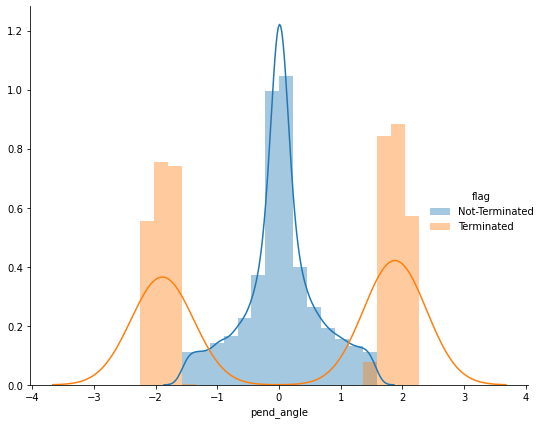

In [5]:
plot_distribution(obs_df, 'pend_angle')

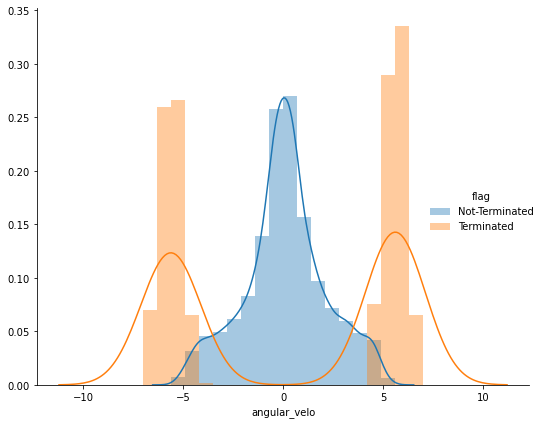

In [6]:
plot_distribution(obs_df, 'angular_velo')

- Here, we can see that the values at positive and negative extremes (tails) corresponds to terminal states

- Now, as mentioned at top, I create a separate (reduced) dataset which will exclude the 4 states that lead to terminal states
    - E.g., assume there is a sequence of states in the order (s1,s2,s3,s4,s5,s6,s7,s8,s9,TERMINAL-STATE, s11, s12, ...) stored in the original dataset, the new dataset will only include (s1,s2,s3,s4,s5,s11,s12,...)

In [7]:
episode_count = []
episodic_step = []

epi_step_count = 0
epi_count = 1

for idx, row in obs_df.iterrows():
    
    epi_step_count += 1   
        
    if row.flag == 'Terminated':
        episodic_step.append(epi_step_count)
        epi_step_count = 0
        
        episode_count.append(epi_count)
        epi_count +=1
        continue
        
    episode_count.append(epi_count)
    episodic_step.append(epi_step_count)
        
obs_df = pd.concat([obs_df
                    , pd.Series(episodic_step,name='episodic_step')
                    , pd.Series(episode_count ,name='episode_num')],axis=1)

In [8]:
obs_df.head(10)

,step,pend_angle,angular_velo,flag,episodic_step,episode_num
0,0,0.040380,0.668674,Not-Terminated,1,1
1,1,0.083226,0.428463,Not-Terminated,2,1
2,2,0.159015,0.757887,Not-Terminated,3,1
3,3,0.196442,0.374270,Not-Terminated,4,1
4,4,0.259310,0.628680,Not-Terminated,5,1
5,5,0.365570,1.062595,Not-Terminated,6,1
6,6,0.587125,2.215549,Not-Terminated,7,1
7,7,0.871385,2.842607,Not-Terminated,8,1
8,8,1.267607,3.962217,Not-Terminated,9,1
9,9,1.811127,5.435199,Terminated,10,1


In [9]:
# Identify number of steps to select from each episode (after removing 4 states leading to terminal state)
epi_n_epi_steps_fil_df = obs_df.groupby(['episode_num']).episodic_step.max().reset_index()
epi_n_epi_steps_fil_df.loc[:,'epi_steps_to_use'] = epi_n_epi_steps_fil_df.episodic_step.apply(lambda val: max(0,val-5))

obs_df = obs_df.merge(right = epi_n_epi_steps_fil_df.loc[:,['episode_num', 'epi_steps_to_use']]
                     , right_on='episode_num'
                     , left_on = 'episode_num'
                     , how = 'left')

obs_df.head(20)

,step,pend_angle,angular_velo,flag,episodic_step,episode_num,epi_steps_to_use
0,0,0.040380,0.668674,Not-Terminated,1,1,5
1,1,0.083226,0.428463,Not-Terminated,2,1,5
2,2,0.159015,0.757887,Not-Terminated,3,1,5
3,3,0.196442,0.374270,Not-Terminated,4,1,5
4,4,0.259310,0.628680,Not-Terminated,5,1,5
5,5,0.365570,1.062595,Not-Terminated,6,1,5
6,6,0.587125,2.215549,Not-Terminated,7,1,5
7,7,0.871385,2.842607,Not-Terminated,8,1,5
8,8,1.267607,3.962217,Not-Terminated,9,1,5
9,9,1.811127,5.435199,Terminated,10,1,5


In [10]:
# Empty list to store the selected rows for the reduced dataset
filter_df_rows = []

# Iterate over rows; only select the states/rows accoding to 'epi-steps-to-use' values
for idx, row in obs_df.iterrows():
    
    if row.episodic_step <= row.epi_steps_to_use:
        filter_df_rows.append(row)
    
obs_df_reduced = pd.concat(filter_df_rows,axis=1).T

In [11]:
obs_df_reduced.head(10)

,step,pend_angle,angular_velo,flag,episodic_step,episode_num,epi_steps_to_use
0,0,0.0403802,0.668674,Not-Terminated,1,1,5
1,1,0.0832265,0.428463,Not-Terminated,2,1,5
2,2,0.159015,0.757887,Not-Terminated,3,1,5
3,3,0.196442,0.37427,Not-Terminated,4,1,5
4,4,0.25931,0.62868,Not-Terminated,5,1,5
10,10,-0.0821831,-0.337827,Not-Terminated,1,2,2
11,11,-0.199304,-1.17121,Not-Terminated,2,2,2
17,17,0.105645,0.68696,Not-Terminated,1,3,3
18,18,0.121116,0.154706,Not-Terminated,2,3,3
19,19,0.226321,1.05205,Not-Terminated,3,3,3


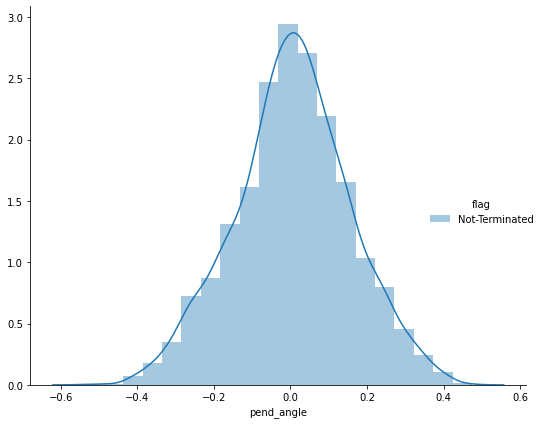

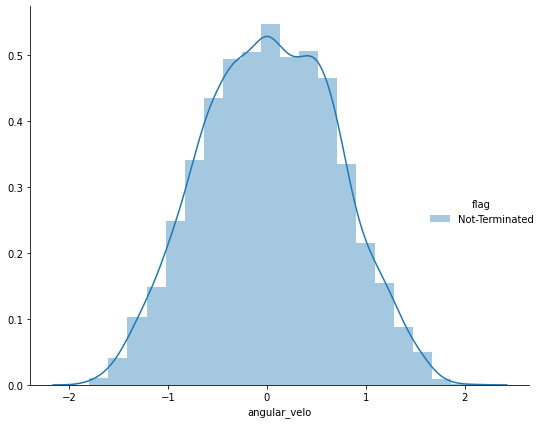

(None, None)

In [12]:
plot_distribution(obs_df_reduced, 'pend_angle'), plot_distribution(obs_df_reduced, 'angular_velo')

- We can see that the reduced dataset doesn't include any terminal states, and also the tails of the stata value distributions have been pruned

### Preparing different initial state groups

- We have to create 2 initial state sets from the collected `pendulum angle` data distribution.
    - My aim is to draw values from artificially simulated skewed distributions for the `pendulum angle` data.
        - I use the statistics of the gathered `pendulum angle` data to generate the simulated (skewed) data distributions
        - Afterwards, I will use the gathered `angular velocity` data to match observed angular velocity values for the artificially generated `pendulum angle` values to create complete state variables.
    

- Let's first observe the distribution of the `pendulum angle` of the collected data

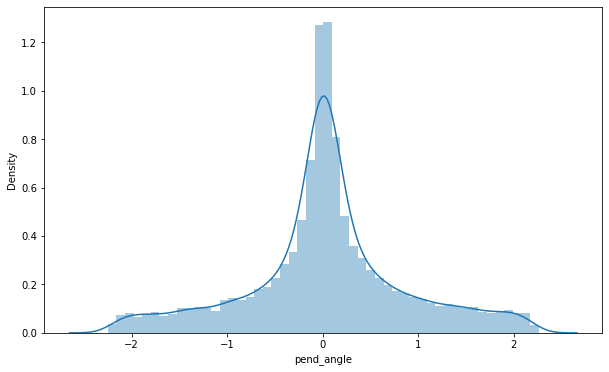

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(obs_df.pend_angle, ax=ax)
plt.show()

In [14]:
obs_df.pend_angle.quantile(0.35)

-0.09939620085060602

In [15]:
print(obs_df.pend_angle.describe())

curr_max = obs_df.pend_angle.describe()['max']
curr_min = obs_df.pend_angle.describe()['min']
curr_std = obs_df.pend_angle.describe()['std']
curr_25_pctile = obs_df.pend_angle.describe()['25%']
curr_75_pctile = obs_df.pend_angle.describe()['75%']

# New quantiles to get better results for the experiments
curr_35_pctile = obs_df.pend_angle.quantile(0.35)
curr_65_pctile = obs_df.pend_angle.quantile(0.65)

count    10000.000000
mean         0.038936
std          0.838797
min         -2.250422
25%         -0.279315
50%          0.020684
75%          0.383186
max          2.263593
Name: pend_angle, dtype: float64


- Now, in order to create two (left and right) skewed distributions,
    - I will bound the resulting skewed distributions to be within the same `max` and `min` values of the observered distribution
    - I will use half of the observed `std` since the resulting distributions are ought to be skewed
    - I will set the mean values of the left and right skewed distributions to the 35th and 65th percentiles of the observed distribution

In [16]:
## Code snipped taken from: https://stackoverflow.com/questions/49801071/how-can-i-use-skewnorm-to-produce-a-distribution-with-the-specified-skew
def create_skew_dist(mean, sd, skew, cutoff_max, cutoff_min, size):

    # calculate the degrees of freedom 1 required to obtain the specific skewness statistic, derived from simulations
    loglog_slope = -2.211897875506251 
    loglog_intercept = 1.002555437670879 
    df2 = 500
    df1 = 10**(loglog_slope*np.log10(abs(skew)) + loglog_intercept)

    # sample from F distribution
    fsample = np.sort(stats.f(df1, df2).rvs(size=size))
    
    # adjust the variance by scaling the distance from each point to the distribution mean by a constant, derived from simulations
    k1_slope = 0.5670830069364579
    k1_intercept = -0.09239985798819927
    k2_slope = 0.5823114978219056
    k2_intercept = -0.11748300123471256

    scaling_slope = abs(skew)*k1_slope + k1_intercept
    scaling_intercept = abs(skew)*k2_slope + k2_intercept

    scale_factor = (sd - scaling_intercept)/scaling_slope    
    new_dist = (fsample - np.mean(fsample))*scale_factor + fsample

    # flip the distribution if specified skew is negative
    if skew < 0:
        new_dist = np.mean(new_dist) - new_dist

    # adjust the distribution mean to the specified value
    final_dist = new_dist + (mean - np.mean(new_dist))

    # remove the outlier values based on current max and min values
    final_dist = final_dist[(final_dist>=cutoff_min) & (final_dist<=cutoff_max) ]
    
    return final_dist

In [17]:
# Left-skewed `pendulum angle` distribution
left_skewed_pend_angle_dist = create_skew_dist(mean = curr_35_pctile
                                                , sd = curr_std/2
                                                , skew = 1.
                                                , cutoff_max = curr_max
                                                , cutoff_min = curr_min
                                                , size = 1000000)

# right-skewed `pendulum angle` distribution
right_skewed_pend_angle_dist = create_skew_dist(mean = curr_65_pctile
                                                 , sd = curr_std/2
                                                 , skew = -1.
                                                 , cutoff_max = curr_max
                                                 , cutoff_min = curr_min
                                                 , size = 1000000)


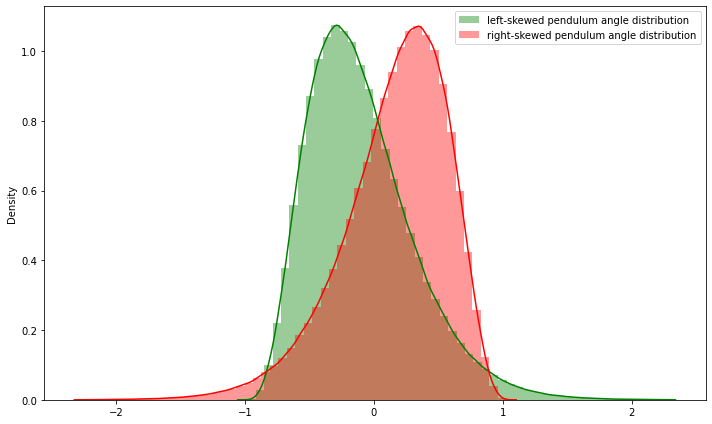

In [18]:
# inspect the plots & moments, try random sample
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(left_skewed_pend_angle_dist
             , hist=True
             , ax=ax
             , color='green'
             , label='left-skewed pendulum angle distribution')

sns.distplot(right_skewed_pend_angle_dist
             , hist=True
             , ax=ax
             , color='red'
             , label='right-skewed pendulum angle distribution')


ax.legend()
plt.tight_layout()
plt.show()

- Since our interest is to sample 40 initial states from each of these distributions, let's do that to confirm the resulting sampling distribution would hold the same skewness

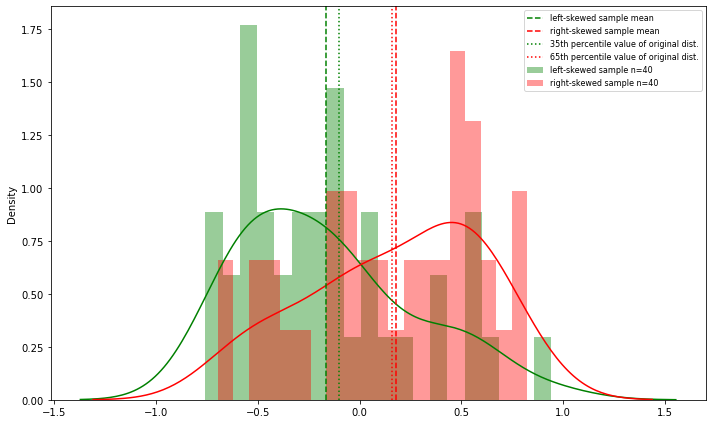

In [19]:
np.random.seed(16)

left_skewed_pend_angle_sample = np.random.choice(left_skewed_pend_angle_dist, size=40)
right_skewed_pend_angle_sample = np.random.choice(right_skewed_pend_angle_dist, size=40)

fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(left_skewed_pend_angle_sample
             , hist=True
             , ax=ax
             , color='green'
             , bins = 20
             , hist_kws={'alpha':.4}
             , label='left-skewed sample n=40')

sns.distplot(right_skewed_pend_angle_sample
             , hist=True
             , ax=ax
             , color='red'
             , bins = 20
             , hist_kws={'alpha':.4}
             , label='right-skewed sample n=40')

ax.axvline(left_skewed_pend_angle_sample.mean(),color='green', linestyle = '--', label = 'left-skewed sample mean')
ax.axvline(right_skewed_pend_angle_sample.mean(),color='red', linestyle = '--', label = 'right-skewed sample mean')
ax.axvline(curr_35_pctile,color='green', linestyle = ':', label = '35th percentile value of original dist.')
ax.axvline(curr_65_pctile,color='red', linestyle = ':', label = '65th percentile value of original dist.')

ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

Above diagram shows that:
- sampled pendulum angle values are skewed as expected
- sample means are closer to the 35th and 65th percentile values of the original pendulum angle value distribution

Therefore, we can use these sample pendulum angle values to define the two skewed initial state distributions.

#### Generating corresponding 'Angular Velocity' values for the generated 'Pendulum Angle' Values

- Next, we need to find corresponding and probable `angular velocity` values for the generated skewed `pendulum angle` values.
- For this, I randomly sample `angular velocity` values from the observed state dataset by following the below criteria:
    - Say we have a pendulum angle value of X (in the skewed distribution):
    - I define an interval [X +/- 0.005] for this value
    - Next, I will look at the original state distribution and select the `pendulum angle - angular velocity` pairs where the `pendulum angle` values lie in the above interval.
    - Finally, I compute the mean `angular velocity` value from the selected set of values.
    

In [20]:
# Process the left-skewed sample dataset
left_skwd_sample_df = pd.DataFrame(left_skewed_pend_angle_sample
                                   , columns=['pend_angle_l_skwd'])
left_skwd_sample_df = left_skwd_sample_df.reset_index()

# Define the lower and upper bound on the pendulum angle values
left_skwd_sample_df.loc[:,'pend_angle_l_skwd_b_upper'] = left_skwd_sample_df.pend_angle_l_skwd.apply(lambda val: val+0.005)
left_skwd_sample_df.loc[:,'pend_angle_l_skwd_b_lower'] = left_skwd_sample_df.pend_angle_l_skwd.apply(lambda val: val-0.005)


# Process the right-skewed sample dataset
right_skwd_sample_df = pd.DataFrame(right_skewed_pend_angle_sample
                                   , columns=['pend_angle_r_skwd'])
right_skwd_sample_df = right_skwd_sample_df.reset_index()

# Define the lower and upper bound on the pendulum angle values
right_skwd_sample_df.loc[:,'pend_angle_r_skwd_b_upper'] = right_skwd_sample_df.pend_angle_r_skwd.apply(lambda val: val+0.005)
right_skwd_sample_df.loc[:,'pend_angle_r_skwd_b_lower'] = right_skwd_sample_df.pend_angle_r_skwd.apply(lambda val: val-0.005)

In [21]:
# Function to loop through the sampled pendulum angle values
# This loops through every row of the dataset
#  and finds the rows ('pendulum angle - angular velocity' pairs) from the original state value dataset
#  where the pendulum angles lie within the computed bounds
# Afterwards, it computes the mean value of the selected 'angular velocity' values of the selected pairs

def compute_angular_velocity(df_row):
    
    pend_angle = df_row[1] # Second column contains the generated pendulum angle
    upper_b = df_row[2]    # Third column contains the computed uppre bound on the pendulum angle
    lower_b = df_row[3]    # Fourth column contains the computed lower bound on the pendulum angle
    
    ang_vel = np.array(obs_df.loc[(obs_df.pend_angle<=upper_b) & (obs_df.pend_angle>=lower_b),'angular_velo'].values).mean()
    
    return (pend_angle,ang_vel)

In [22]:
# Create the final right-skewewd inititial state set
pend_angle_angu_velo_pairs = []
for idx, row in right_skwd_sample_df.iterrows():
    pend_angle_angu_velo_pairs.append(compute_angular_velocity(row))
    
right_skewed_sample_final = pd.DataFrame(np.array(pend_angle_angu_velo_pairs), columns=['pend_angle','angular_velo'])


# Create the final left-skewewd initial state set
pend_angle_angu_velo_pairs = []
for idx, row in left_skwd_sample_df.iterrows():
    pend_angle_angu_velo_pairs.append(compute_angular_velocity(row))
    
left_skewed_sample_final = pd.DataFrame(np.array(pend_angle_angu_velo_pairs), columns=['pend_angle','angular_velo'])

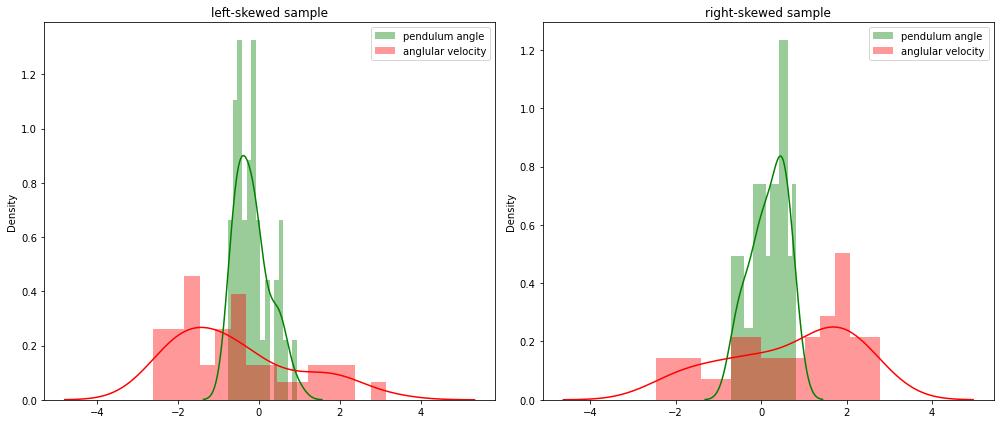

In [23]:
# inspect the plots
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

sns.distplot(left_skewed_sample_final.pend_angle
             , hist=True
             , ax=ax[0]
             , color='green'
             , bins = 15
             , label='pendulum angle')

sns.distplot(left_skewed_sample_final.angular_velo
             , hist=True
             , ax=ax[0]
             , bins = 15
             , color='red'
             , label='anglular velocity')

ax[0].legend()
ax[0].set_xlabel("")
ax[0].set_title("left-skewed sample")

sns.distplot(right_skewed_sample_final.pend_angle
             , hist=True
             , ax=ax[1]
             , color='green'
             , bins = 15
             , label='pendulum angle')

sns.distplot(right_skewed_sample_final.angular_velo
             , hist=True
             , ax=ax[1]
             , bins = 15
             , color='red'
             , label='anglular velocity')

ax[1].legend()
ax[1].set_xlabel("")
ax[1].set_title("right-skewed sample")

plt.tight_layout()
plt.show()

- By observing the above figure, we can see that the selected `angular velocity` values seem to also be skewed.

#### Creating the third (uniformly sampled) initial state set

Finally, I create the third sample by following below steps:
 - Sample `pendulum angle` values from the `reduced-dataset` (which have been pruned after excluding terminal states and states close to terminal states)
    - Here, I randomly draw a sample of size 40, hoping that it will approximate the underlying true distribution of both 'pendulum angle' and 'angular velocity' values)

In [26]:
# Draw a random sample of size 40 (indexes of the `obs_df_reduced` dataframe)
np.random.seed(15)

idx = np.random.choice(obs_df_reduced.index.values, size=40)
uniformly_sampled_sample_final = obs_df_reduced.loc[obs_df_reduced.index.isin(idx),['pend_angle','angular_velo']]
uniformly_sampled_sample_final.reset_index(drop=True, inplace=True)

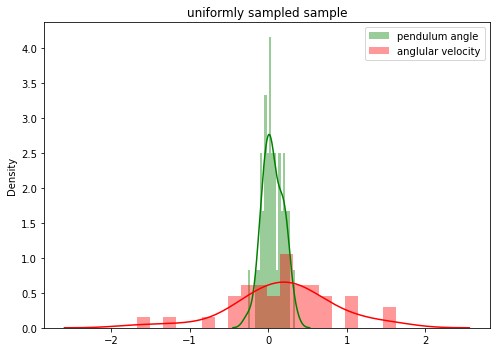

In [28]:
# inspect the plot
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(uniformly_sampled_sample_final.pend_angle
             , hist=True
             , ax=ax
             , color='green'
             , bins = 20
             , label='pendulum angle')

sns.distplot(uniformly_sampled_sample_final.angular_velo
             , hist=True
             , ax=ax
             , bins = 20
             , color='red'
             , label='anglular velocity')

ax.legend()
ax.set_xlabel("")
ax.set_title("uniformly sampled sample")

plt.tight_layout()
plt.show()

#### Finally, let's export the stored initial state values of the three groups in order to use them as initial states when running the PbPI algorithm.

- Before doing that, we have to combine the computed `pendulum angle` and `angular velocity` state values with `cart_position` and `cart_velocity` state values.
- This is because, the environment that we work with is 4-dimensional
- It is okay to set `cart-position=0` since the computed two state values are not related to the position of the cart.
- However, `cart-velocity` and the computed two state variables are related.
- Therefore, we have to compute a meaningul `cart-velocity` state value for every initial state.
 - We do this the same way how we computed `angular velocity` for `pendulum angle` values.
 - I.e., we compute the average `cart-velocity` value among the gathered states values as follows:
     - Assume our state is (X,Y) where X is the pendulum angle and Y is the angular velocity.
     - We define a upper and lower bound on both X and Y values by +/- 0.05 from each
     - Afterwards, we select the states having pendulum angle and angular velocity values within the computed bounds.
     - Finally, we select the average 'cart-velocity' value from the selected states

In [29]:
def create_full_state_sample(df):

    df.loc[:,'pend_angle_b_upper'] = df.pend_angle.apply(lambda val: val+0.05)
    df.loc[:,'pend_angle_b_lower'] = df.pend_angle.apply(lambda val: val-0.05)

    df.loc[:,'angular_velo_b_upper'] = df.angular_velo.apply(lambda val: val+0.05)
    df.loc[:,'angular_velo_b_lower'] = df.angular_velo.apply(lambda val: val-0.05)

    def compute_full_state(df_row):

        pend_angle = df_row[0] # First column contains the generated pendulum angle
        angular_vel = df_row[1] # Second column contains the generated angular velocity


        upper_pend_angle_b = df_row[2]    # Third column contains the computed uppre bound on the pendulum angle
        lower_pend_angle_b = df_row[3]   # Fourth column contains the computed lower bound on the pendulum angle

        upper_angu_vel_b = df_row[4]    # Fifth column contains the computed uppre bound on the angular velocity
        lower_angu_vel_b = df_row[5]    # Fourth column contains the computed lower bound the angular velocity

        cart_vel = np.array(full_state_df.loc[(full_state_df.pend_angle <= upper_pend_angle_b) & \
                                             (full_state_df.pend_angle >= lower_pend_angle_b) & \
                                             (full_state_df.angular_velo <= upper_angu_vel_b) & \
                                             (full_state_df.angular_velo >= lower_angu_vel_b) ,'cart_velocity'].values).mean()

        cart_posi = 0 # set cart-position to be zero

        return (cart_posi, cart_vel, pend_angle, angular_vel)

    # Create the final right-skewewd inititial state set
    full_state_value_pairs = []

    for idx, row in df.iterrows():
        full_state_value_pairs.append(compute_full_state(row))

    final_df = pd.DataFrame(np.array(full_state_value_pairs), columns=['cart_position'	,'cart_velocity','pend_angle','angular_velo'])
    
    return final_df


In [30]:
right_skewed_sample_final_complete = create_full_state_sample(right_skewed_sample_final)
left_skewed_sample_final_complete = create_full_state_sample(left_skewed_sample_final)
uniformly_sampled_sample_final_complete = create_full_state_sample(uniformly_sampled_sample_final)

In [31]:
right_skewed_sample_final_complete.to_csv('init_state_data/right_skewed_states.csv', index=False)
left_skewed_sample_final_complete.to_csv('init_state_data/left_skewed_states.csv', index=False)
uniformly_sampled_sample_final_complete.to_csv('init_state_data/uniformly_sampled_states.csv', index=False)

---
### Sampling from a equally partitioned state space

- In this section, I divide the **Pendulum Angle** state variable into to 20 equal partitions and select 21 equally distant values.
- Afterwards, I generate a pool of 100,000 states (similiar to how the initial state pool was created at the top of this notebook) and use those state to generate state-value distributions of the remaining state variables at the selected 21 equally distant pendulum angle values.


In [34]:
# The maximum and minimum values of the Pendulum Angle state variable 
# are -1.57 rads (-90 degrees) and +1.57 rands (+90 degrees) respectively

left_max_rad = -3.14/2
right_max_rad = 3.14/2

pend_angle_points = np.linspace(left_max_rad, right_max_rad, 21)

print("Selected Pendulum Angle Values are:", ", ".join([str(round(val,2)) for val in pend_angle_points]))

Selected Pendulum Angle Values are: -1.57, -1.41, -1.26, -1.1, -0.94, -0.78, -0.63, -0.47, -0.31, -0.16, 0.0, 0.16, 0.31, 0.47, 0.63, 0.78, 0.94, 1.1, 1.26, 1.41, 1.57


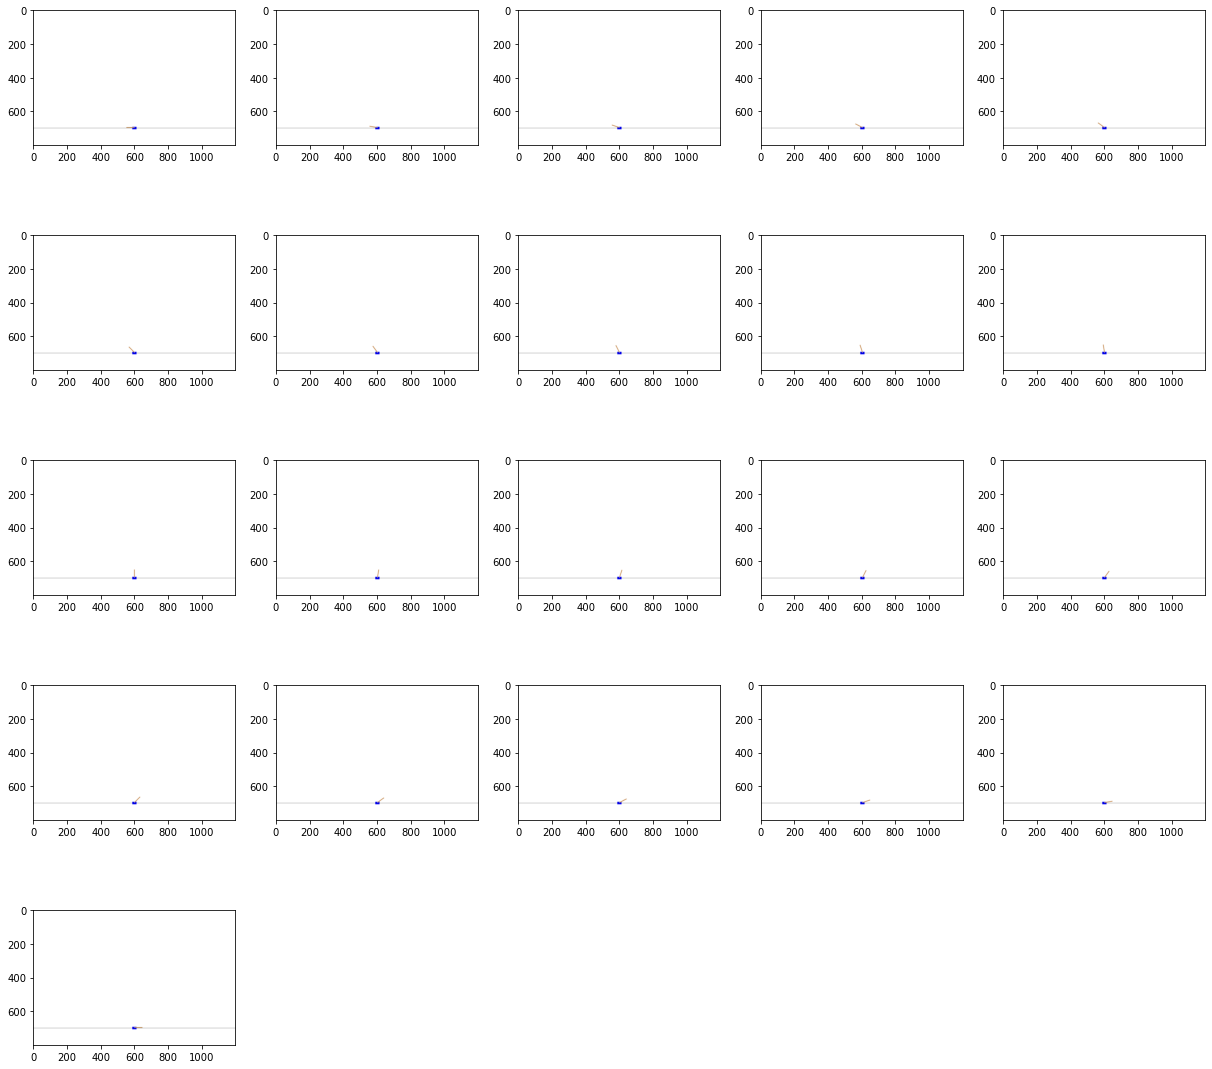

In [35]:
# Let's plot the selected Pendulum angles and see how the look 
sample_size =  len(pend_angle_points)

env = gym.make('CustomCartPole-v0')
fig = plt.figure(figsize=(sample_size, 2*int(sample_size/2)))

for i in range(sample_size):
    env.reset(init_state = [0, 0, pend_angle_points[i],0]) # set state
    fig.add_subplot(int(sample_size/4), 5, i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

In [36]:
# Next, I generate the 100,000 state pool in order to draw the
# state value distributions for the remaining state variables.

obs_100_000_df, full_state_100_000_df =  create_state_pool(n_steps=100_000)
obs_100_000_df.head()

100%|██████████| 100000/100000 [01:09<00:00, 1448.89it/s]


,step,pend_angle,angular_velo,flag
0,0,-0.052911,-0.658700,Not-Terminated
1,1,-0.123360,-0.704484,Not-Terminated
2,2,-0.170544,-0.471847,Not-Terminated
3,3,-0.212080,-0.415360,Not-Terminated
4,4,-0.343860,-1.317796,Not-Terminated


In [97]:
# Randomly select 2 pendulum angles from the equally divided partitions
# This gives 40 pendulum angles in total

# Randomly select 2 values from each interval
pend_ang_sample = np.array([np.random.uniform(pair[0], pair[1], 2) for pair in \
                    zip(pend_angle_points[:], pend_angle_points[1:])]).reshape(-1)

pend_ang_sample

array([-1.56635599, -1.51095924, -1.27056174, -1.27775771, -1.14211698,
       -1.20524728, -1.02832332, -0.97598241, -0.87589307, -0.93450464,
       -0.63028984, -0.70040222, -0.54574173, -0.57677419, -0.41370111,
       -0.31596668, -0.29524689, -0.1745161 , -0.03265794, -0.01332439,
        0.1515819 ,  0.11918762,  0.23768825,  0.21884565,  0.37968844,
        0.37731102,  0.53349281,  0.5908815 ,  0.76494401,  0.77598415,
        0.82688443,  0.89500705,  0.94889   ,  1.01588009,  1.12043068,
        1.1364122 ,  1.39071834,  1.31622465,  1.52508136,  1.5168159 ])

In [99]:
# Create a dataset with equally distant pendulum angles
equ_dist_sample_df = pd.DataFrame(pend_ang_sample
                                   , columns=['pend_angle_equ_dist_samples'])
equ_dist_sample_df.head()

,pend_angle_equ_dist_samples
0,-1.566356
1,-1.510959
2,-1.270562
3,-1.277758
4,-1.142117


In [100]:
# Define the lower and upper bound on the pendulum angle values
equ_dist_sample_df.loc[:,'pend_angle_b_upper'] = equ_dist_sample_df.pend_angle_equ_dist_samples.apply(lambda val: val+0.005)
equ_dist_sample_df.loc[:,'pend_angle_b_lower'] = equ_dist_sample_df.pend_angle_equ_dist_samples.apply(lambda val: val-0.005)

In [101]:
equ_dist_sample_df.head(10)

,pend_angle_equ_dist_samples,pend_angle_b_upper,pend_angle_b_lower
0,-1.566356,-1.561356,-1.571356
1,-1.510959,-1.505959,-1.515959
2,-1.270562,-1.265562,-1.275562
3,-1.277758,-1.272758,-1.282758
4,-1.142117,-1.137117,-1.147117
5,-1.205247,-1.200247,-1.210247
6,-1.028323,-1.023323,-1.033323
7,-0.975982,-0.970982,-0.980982
8,-0.875893,-0.870893,-0.880893
9,-0.934505,-0.929505,-0.939505


In [102]:
full_state_100_000_df.head()

,step,cart_position,cart_velocity,pend_angle,angular_velo
0,0,-0.001196,0.480866,-0.052911,-0.658700
1,1,0.044757,0.459530,-0.123360,-0.704484
2,2,0.062931,0.181742,-0.170544,-0.471847
3,3,0.060407,-0.025243,-0.212080,-0.415360
4,4,0.098322,0.379157,-0.343860,-1.317796


In [103]:
def compute_state_value_distributions(df_row, df):
    """
    Generates the angular velocity and cart-velocity distributions for a given
    pendulum angle value.
    """

    threshold = 0.005

    pend_angle = df_row[0]    # Second column contains the generated pendulum angle
    upper_b    = df_row[1]    # Third column contains the computed uppre bound on the pendulum angle
    lower_b    = df_row[2]    # Fourth column contains the computed lower bound on the pendulum angle
    
    # Compute the angular velocity distribution
    ang_vel_dist  = np.array(df.loc[(df.pend_angle <= upper_b) & (df.pend_angle >= lower_b), 'angular_velo'].values)
    ang_vel_mean  = np.mean(ang_vel_dist) # Angular velocity mean
    ang_vel_mean_ub = ang_vel_mean + threshold # Angular velocity upper bound
    ang_vel_mean_lb = ang_vel_mean - threshold  # Angular velocity lower bound

    # Compute cart velocity distribution
    cart_vel_dist  = np.array(df.loc[(df.angular_velo <= ang_vel_mean_ub) & (df.angular_velo >= ang_vel_mean_lb), 'cart_velocity'].values)
    cart_vel_mean  = np.mean(cart_vel_dist) # Angular velocity mean

    
    return (pend_angle, ang_vel_mean, cart_vel_mean) , (ang_vel_dist, cart_vel_dist)


# Create the dataset with angular velocity d inititial state set
state_val_distributions = []
for idx, row in tqdm.tqdm(equ_dist_sample_df.iterrows()):
    state_val_distributions.append(compute_state_value_distributions(row, full_state_100_000_df))
    


40it [00:00, 314.22it/s]


In [104]:
pend_angle, ang_vel, cart_vel = zip(*pd.DataFrame(np.array(state_val_distributions)[:,0])[0])

In [111]:
# Create the dataset with Pendulum angle and mean-angular velocity and
# mean-cart velocity values
equ_dist_partitions_samples_df = pd.DataFrame({'pendulum_angle'    : pend_angle
                                                , 'angular_velocity' : ang_vel
                                                , 'cart_velocity'    : cart_vel
                                                , 'cart_position'    : 0 })

equ_dist_partitions_samples_df

,pendulum_angle,angular_velocity,cart_velocity,cart_position
0,-1.566356,-4.883498,0.606452,0
1,-1.510959,-4.656474,0.473110,0
2,-1.270562,-4.064517,0.639852,0
3,-1.277758,-4.092405,0.656735,0
4,-1.142117,-3.737292,0.702841,0
5,-1.205247,-3.913808,0.737213,0
6,-1.028323,-3.423493,0.702856,0
7,-0.975982,-3.277425,0.559874,0
8,-0.875893,-3.002797,0.582193,0
9,-0.934505,-3.159538,0.748392,0


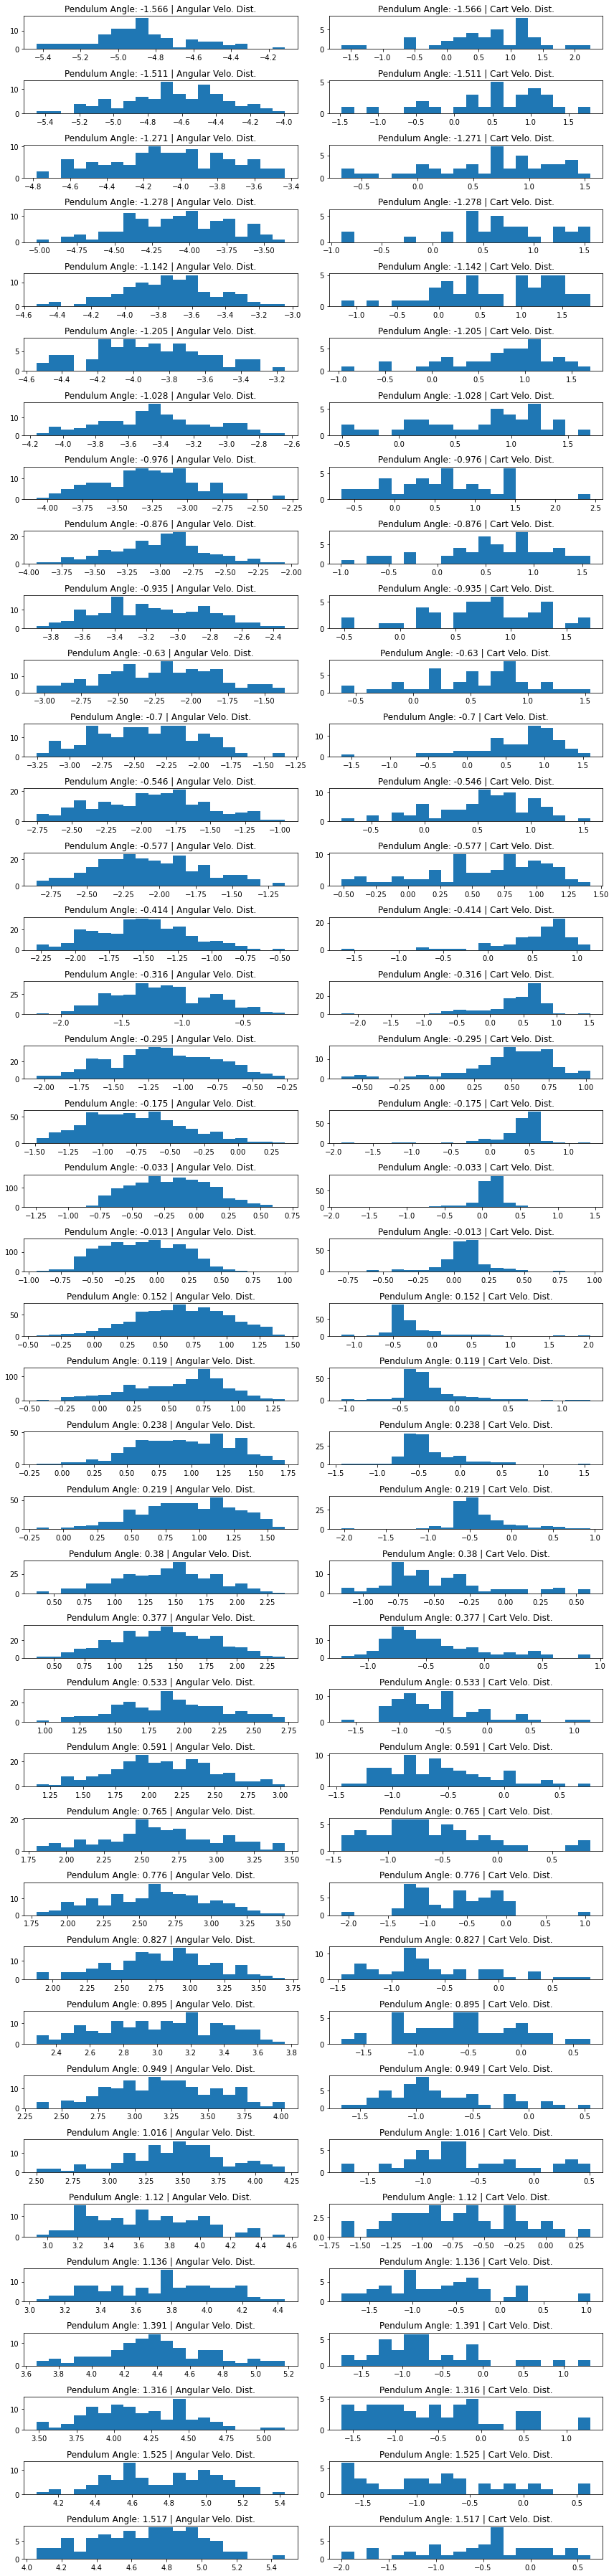

In [107]:
# Plot the distributions of the Angular Velocity and Cart Velocity 
# for the selected pendulum angle values
fig, ax = plt.subplots(ncols = 2
                        , nrows=int(len(pend_angle))
                        , figsize = (12,50))

for x, p_angle in enumerate(pend_angle):
    for y in [0,1]:
        ax[x,y].hist(np.array(state_val_distributions)[:,1][x][y], 20)
        ax[x,y].set_title(f"Pendulum Angle: { str(round(p_angle, 3)) } | {'Angular Velo. Dist.' if y==0 else 'Cart Velo. Dist.'}")

plt.tight_layout()

In [113]:
equ_dist_partitions_samples_df.to_csv('init_state_data/equ_distant_sample_states.csv', index=False)

---
### Evaluation results from the experiments - THIS PART NEEDS TO BE REFINED BASED ON NEW RESULTS

- For each initial state distribution, we ran 120 experiments to test below parameter configurations:
    - No. actions: 3
    - No. initial states: 40
    - No. rollouts: (10, 20, 50, 100)
    - No. sig. levels: (0.025, 0.05, 0.1)
    - No. experiment runs per parameter config: 10

- As we can see [here](https://nbviewer.jupyter.org/github/PandulaP/RL_Research/blob/main/Pb_policy_iteration/cart_pole_modified_env/initial_state_analysis/init_state_eval_results.ipynb) and on the below figure, only the experiments that started with the **unbiased initial state distribution** was able to find sufficient policies.

<center><img src="graphics/init_state_exp_eval_plot_40_states.png"  height="500" ></center>

Therefore, this confirms our assumption that **the initial state distribution affects the performance of the PbPI algorithm.**

---
### Experimenting with small and large initial unbiased state sets - THIS PART NEEDS TO BE REFINED WITH NEW RESULTS

- Above experiment used 40 initial states for the experiments.
- As we know, large state sets are likely to approximate the true state distribution more closely.
- Therefore, I run two experiments with a very low (10 states) and a very high (100 states) number of states to see how these different counts will affect the cummulative SR value that I compute in the evaluation plot.
- We saw that the for the state set of a size of 40, ~70% of the experiments found a sufficient policy.
- This experiment will tell us how the sample size will affect the evaluation plot, i.e., if having more initial states will result with a higher number of experiments with sufficient policies.

In [14]:
# Draw a random sample of size 10 and 100
np.random.seed(15)

idx_small = np.random.choice(obs_df_reduced.index.values, size=10)
unbiased_sample_final_small = obs_df_reduced.loc[obs_df_reduced.index.isin(idx_small),['pend_angle','angular_velo']]
unbiased_sample_final_small.reset_index(drop=True, inplace=True)

idx_large = np.random.choice(obs_df_reduced.index.values, size=100, replace=False)
unbiased_sample_final_large = obs_df_reduced.loc[obs_df_reduced.index.isin(idx_large),['pend_angle','angular_velo']]
unbiased_sample_final_large.reset_index(drop=True, inplace=True)

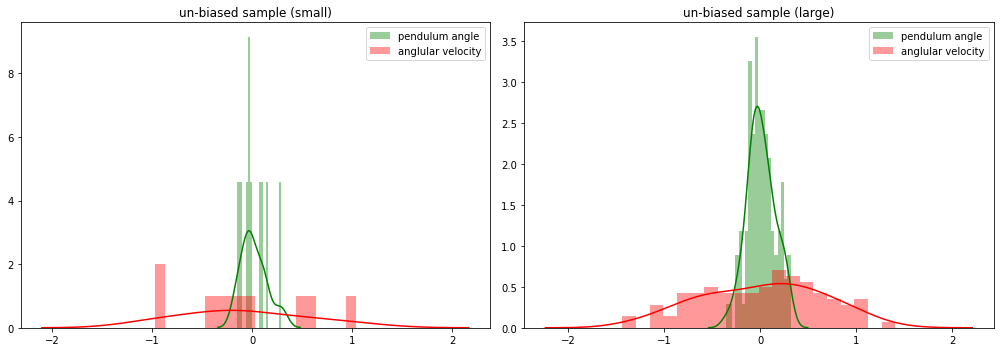

In [16]:
# inspect the plot
fig, ax = plt.subplots(figsize=(14,5), nrows=1, ncols=2)

sns.distplot(unbiased_sample_final_small.pend_angle
             , hist=True
             , ax=ax[0]
             , color='green'
             , bins = 20
             , label='pendulum angle')

sns.distplot(unbiased_sample_final_small.angular_velo
             , hist=True
             , ax=ax[0]
             , bins = 20
             , color='red'
             , label='anglular velocity')

ax[0].legend()
ax[0].set_xlabel("")
ax[0].set_title("un-biased sample (small)")

sns.distplot(unbiased_sample_final_large.pend_angle
             , hist=True
             , ax=ax[1]
             , color='green'
             , bins = 20
             , label='pendulum angle')

sns.distplot(unbiased_sample_final_large.angular_velo
             , hist=True
             , ax=ax[1]
             , bins = 20
             , color='red'
             , label='anglular velocity')

ax[1].legend()
ax[1].set_xlabel("")
ax[1].set_title("un-biased sample (large)")


plt.tight_layout()
plt.show()

In [17]:
unbiased_sample_final_small_complete = create_full_state_sample(unbiased_sample_final_small)
unbiased_sample_final_small_complete.to_csv('init_state_data/unbiased_states_small.csv', index=False)

unbiased_sample_final_large_complete = create_full_state_sample(unbiased_sample_final_large)
unbiased_sample_final_large_complete.to_csv('init_state_data/unbiased_states_large.csv', index=False)

---

In [17]:
equ_dist_sample_df.to_csv('init_state_data/equ_distant_states.csv', index=False)